# Import Lib

Python 3.7.10

In [1]:
import itertools
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import statsmodels.api as sm

from tqdm.notebook import tqdm
from scipy.stats import skew, kurtosis

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.manifold import MDS, TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from utils import plot_confusion_matrix, print_metrics, show_separable, show_sensors

# Download data and preprocessing

In [2]:
CLASSES = ['Mode 1','Mode 2','Mode 3','Mode 4','Mode 5', 'Mode 6']

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test  = np.load('X_test.npy')
y_test  = np.load('y_test.npy')

y_train_class = y_train.argmax(axis=1)
y_test_class  = y_test.argmax(axis=1)

print('X Train shape', X_train.shape)
print('X Test shape ', X_test.shape)

X Train shape (7352, 128, 9)
X Test shape  (2947, 128, 9)


Посмотрим как выглядят графики для каждого сенсора.

0 [0. 0. 0. 0. 1. 0.]


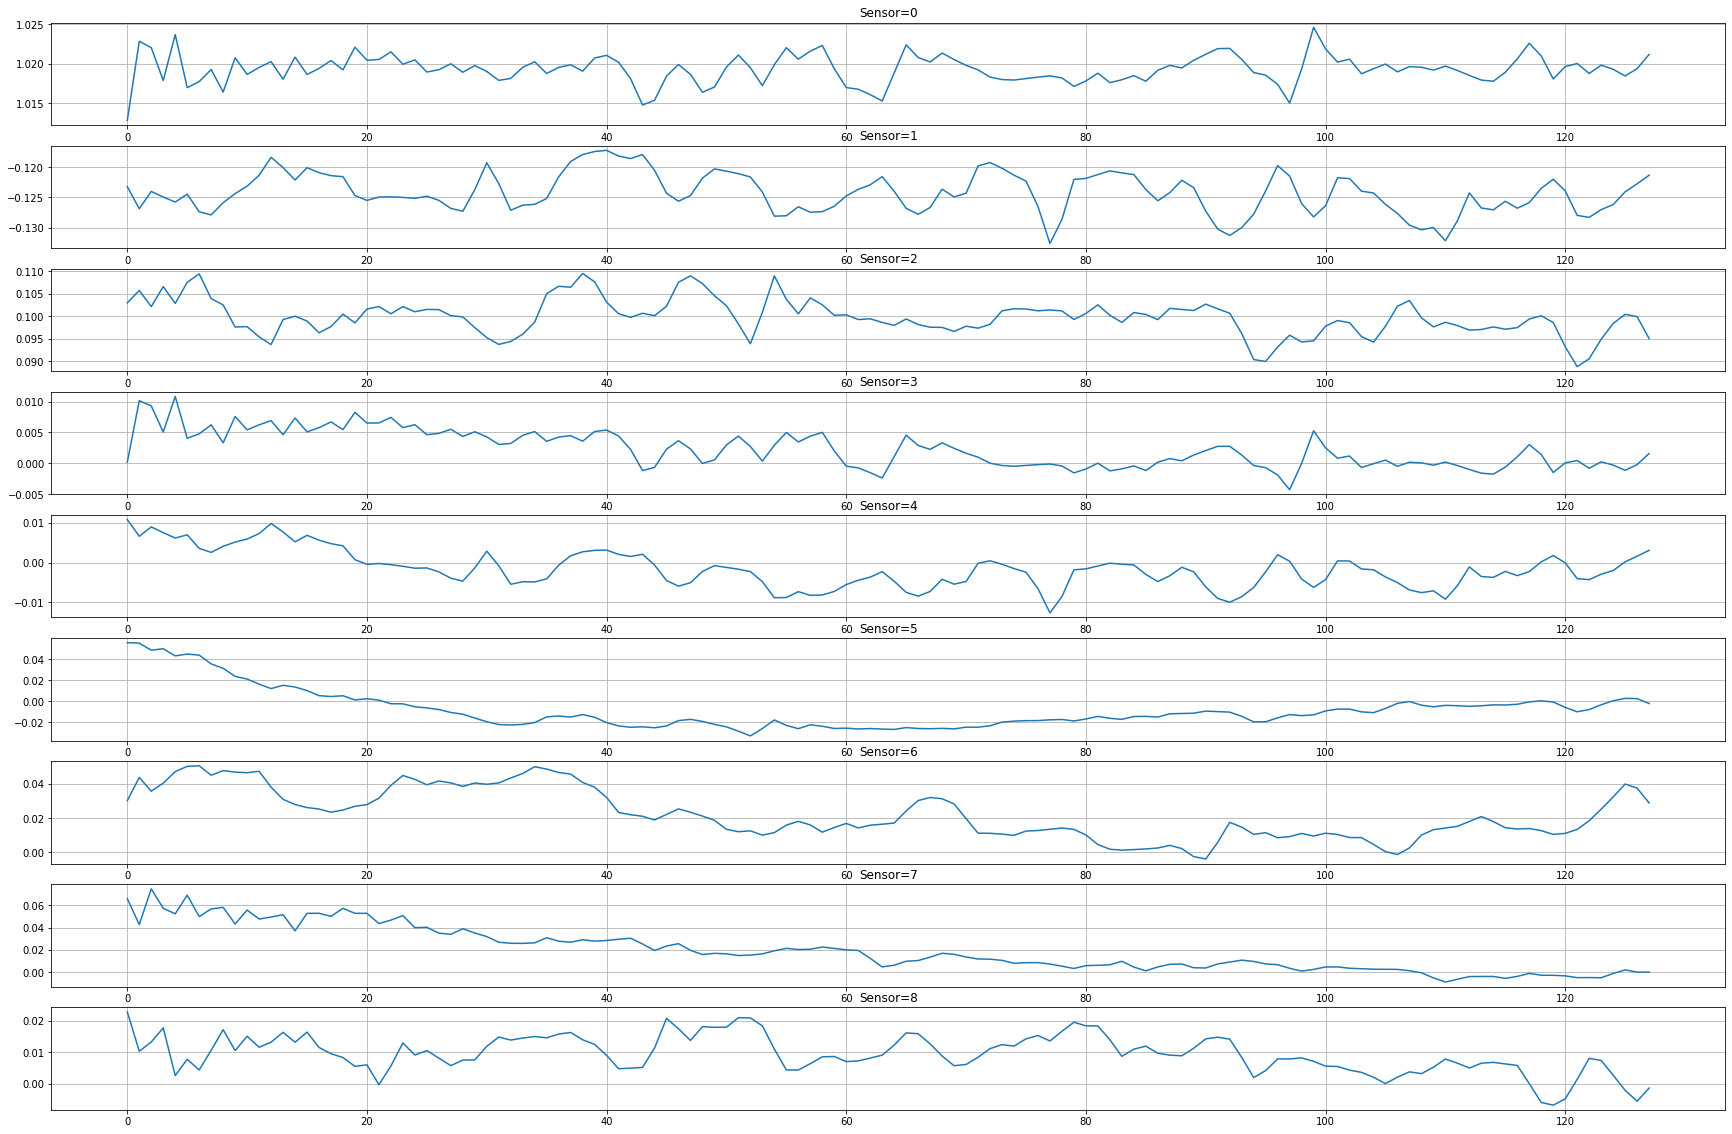

In [3]:
show_sensors(0, X_train, y_train)

Посмотрев на графики для разных приборов - можно сделать вывод, что в болшинстве случаев датчики $S^0_t-S^3_t$, $S^1_t-S^4_t$, $S^2_t-S^5_t$ имеют одинаковое поведение, то есть очень похожие графики. 

В принципе для того, чтобы сделать графики одинаковыми, помогает линейная регрессия: $k\cdot S^i_t + b = S^j_t$

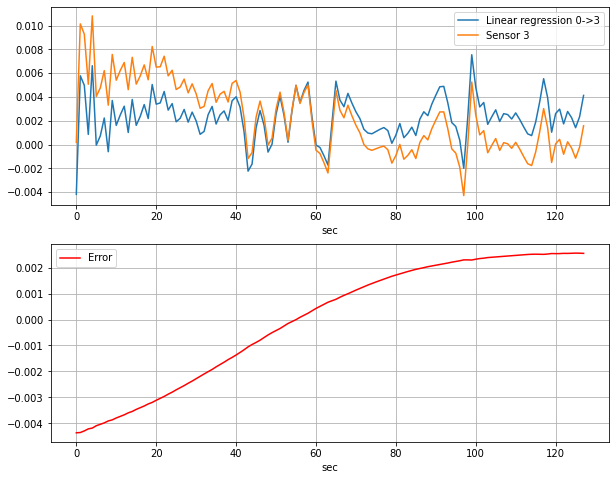

In [4]:
num  = 0
k1   = 0
k2   = 3
A    = np.vstack([X_train[num, :, k1], np.ones(128)]).T
m, c = np.linalg.lstsq(A, X_train[num, :, k2], rcond=None)[0]

plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.plot(m*X_train[num, : , k1]+c)
plt.plot(X_train[num, : , k2])
plt.legend([f'Linear regression {k1}->{k2}',f'Sensor {k2}'])
plt.grid()
plt.xlabel('sec')
plt.subplot(212)
plt.plot(m*X_train[num, : , k1]+c-X_train[num, : , k2], 'red')
plt.grid()
plt.xlabel('sec')
plt.legend(['Error'])
plt.show()

Для многих приборов разница $Err = k\cdot S^i_t + b - S^j_t$ незначительна, с другой стороны для других приборов есть ощутимая разница, потому что в одном из датчиков есть дополнительный возрастающий тренд.

Информацию из $Err$ мы сможем использовать как доп фичи.

Так же параметры линейной регресси можно использовать в качестве фичей.

_______________________________________
# Features

В качестве фич можно использовать следующую информацию: 
1) Информация о самой последовательности: 

    Mean, std, max, min, amplitude - среднее показание датчика, разброс показаний датчика, максимальное и минимальное значение показаний, размах данных за 128 секунд.
    
2) Информация о производной последовательности $dS^k_t = S^k_t - S^k_{t-1}$:
    
    Mean, max - среднее изменение показаний датчика, максимальный скачок показаний датчика. 
    
3) Немного описчательной статистики: 
    
    Skewness, kurtosis - ассиметрия набора данных и эксцесс. 
    
4) Информацию $Err$ о несоответствии показаний датчиков $S^0_t-S^3_t$, $S^1_t-S^4_t$, $S^2_t-S^5_t$:
    
    Mean, max
    
5) Произведение показаний датчиков.

In [5]:
def features_creature(x):
    features_name    = []
    sensor_bijection = {0: 3, 1: 4, 2: 5} 
    bijection_info   = ['k', 'b', 'err_mean', 'err_max']
    features         = ['mean', 'std', 'max', 'min', 'dx_mean', 'dx_max', 'kurtosis', 'skew']
    
    for ax1, ax2 in sensor_bijection.items():
        for feature in bijection_info:
            features_name.append(f'{feature} S{ax1}->S{ax2} ')
            
    for feature in features: 
        for ax in range(9): 
            features_name.append(f'S{ax}_{feature}')
    
    for ax1 in range(8):
        for ax2 in range(ax1+1, 9): 
            features_name.append(f'S{ax1}*S{ax2}_mean')
    
    dx           = x[:, 1:, :]-x[:, :-1, :]
    dx_max       = dx.max(axis=1)
    dx_mean      = dx.mean(axis=1)
    x_f          = []
    
    for i in tqdm(range(len(x))):
        tmp = []
        for ax1, ax2 in sensor_bijection.items():
            A        = np.vstack([x[i, :, ax1], np.ones(128)]).T
            k, b     = np.linalg.lstsq(A, x[i, :, ax2], rcond=None)[0]
            err      = k*x[i, :, ax1]+b - x[i, :, ax2]
            err_mean = np.abs(err).mean()
            err_max  = np.abs(err).max()
            tmp      = np.hstack((tmp, k, b, err_mean, err_max))

        tmp = np.hstack((tmp, x[i, : , :].mean(axis=0), x[i, : , :].std(axis=0)))
        tmp = np.hstack((tmp, x[i, : , :].max(axis=0),  x[i, : , :].min(axis=0)))

        tmp = np.hstack((tmp, dx_mean[i], dx_max[i]))
        tmp = np.hstack((tmp, kurtosis(x[i, :, :]), skew(x[i, :, :])))        
        
        for ax1 in range(8):
            for ax2 in range(ax1+1, 9): 
                XiXj = (x[i, :, ax1]*x[i, :, ax2]).mean()
                tmp  = np.hstack((tmp, XiXj))
        x_f.append(tmp)
        
    x_f = np.array(x_f)
    df  = pd.DataFrame()
    
    for i in range(len(features_name)):
        df[features_name[i]] = x_f[:, i] 
        
    return df, x_f

df_train, x_train_my = features_creature(X_train)
df_test,  x_test_my  = features_creature(X_test)
df_train['Mode']     = y_train_class
df_test['Mode']      = y_test_class

  0%|          | 0/7352 [00:00<?, ?it/s]

  0%|          | 0/2947 [00:00<?, ?it/s]

Посмотрим на распределение классов.

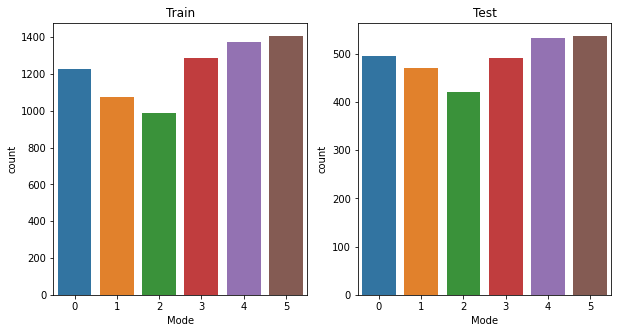

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title('Train')
axs[1].set_title('Test')

sns.countplot(x='Mode', data=df_train, ax=axs[0])
sns.countplot(x='Mode', data=df_test,  ax=axs[1])

plt.show()

Плюс-минус классы сбалансированы. И примерно одинаковое соотношение в тестовом и тренировочном датасетах.

In [7]:
df_train[df_train.columns[:12]].describe()

,k S0->S3,b S0->S3,err_mean S0->S3,err_max S0->S3,k S1->S4,b S1->S4,err_mean S1->S4,err_max S1->S4,k S2->S5,b S2->S5,err_mean S2->S5,err_max S2->S5
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,1.010187,-0.810778,0.004447,0.011764,0.999242,-0.024914,0.006790,0.017535,1.021509,-0.087172,0.007161,0.018791
std,0.328630,0.414437,0.009570,0.029338,0.349456,0.391265,0.010983,0.032103,0.344960,0.373713,0.011012,0.031354
min,-4.593857,-7.859322,0.000025,0.000065,-6.226649,-2.305594,0.000038,0.000125,-3.046671,-3.557806,0.000054,0.000138
25%,1.000166,-1.015074,0.000671,0.001696,0.998626,-0.133903,0.001263,0.003389,0.999182,-0.218914,0.001545,0.004175
50%,1.002381,-0.988531,0.002208,0.005827,1.006035,0.126270,0.003571,0.009440,1.012187,-0.017321,0.003966,0.010263
75%,1.017008,-0.877608,0.005005,0.012192,1.028688,0.223448,0.008226,0.019970,1.051038,0.133327,0.008491,0.021571
max,8.085027,2.588596,0.260687,0.821573,6.219404,2.952897,0.171946,0.734351,9.553369,2.960931,0.217191,0.643818


In [8]:
df_train[df_train.columns[12:30]].describe()

,S0_mean,S1_mean,S2_mean,S3_mean,S4_mean,S5_mean,S6_mean,S7_mean,S8_mean,S0_std,S1_std,S2_std,S3_std,S4_std,S5_std,S6_std,S7_std,S8_std
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.804749,0.028755,0.086498,-0.000636,-0.000292,-0.000275,0.000506,-0.000824,0.000113,0.127444,0.082753,0.070886,0.129105,0.084946,0.073816,0.243794,0.249152,0.168811
std,0.366131,0.372431,0.342719,0.014480,0.021406,0.018709,0.187867,0.059768,0.061655,0.145657,0.085700,0.074392,0.145224,0.085531,0.075001,0.266052,0.283152,0.181965
min,-0.370700,-0.494512,-0.988372,-0.263284,-0.515524,-0.294562,-0.914161,-0.351097,-0.437807,0.001340,0.001510,0.002969,0.001413,0.001748,0.003014,0.001692,0.002003,0.002184
25%,0.902589,-0.220897,-0.127711,-0.003009,-0.004052,-0.004190,-0.016216,-0.013213,-0.009825,0.003414,0.004724,0.005770,0.003758,0.005448,0.006555,0.012037,0.014576,0.008548
50%,0.983997,-0.124932,0.019812,-0.000079,-0.000042,-0.000122,-0.000002,-0.000198,-0.000097,0.013844,0.019710,0.020322,0.018826,0.026928,0.028207,0.078450,0.064882,0.055189
75%,1.011098,0.167153,0.223316,0.002243,0.003333,0.003473,0.017685,0.010035,0.010297,0.245544,0.164297,0.131835,0.246462,0.166063,0.135140,0.454575,0.436557,0.324051
max,1.055335,1.005326,0.977294,0.148878,0.533502,0.366119,0.790661,0.485058,0.404380,0.648704,0.369380,0.356817,0.648675,0.327796,0.361280,1.736491,1.527045,0.966791


In [9]:
df_train[df_train.columns[30:48]].describe()

,S0_max,S1_max,S2_max,S3_max,S4_max,S5_max,S6_max,S7_max,S8_max,S0_min,S1_min,S2_min,S3_min,S4_min,S5_min,S6_min,S7_min,S8_min
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,1.124611,0.196441,0.245178,0.321385,0.171700,0.164147,0.543604,0.662617,0.373870,0.585812,-0.215919,-0.103294,-0.222585,-0.248542,-0.194408,-0.549242,-0.578488,-0.412911
std,0.608197,0.319585,0.306718,0.362830,0.173809,0.170375,0.622313,0.812211,0.408455,0.350926,0.562020,0.488384,0.240953,0.271623,0.218603,0.653148,0.678327,0.464741
min,-0.314170,-0.444567,-0.978027,-0.032683,-0.255647,-0.092621,-0.241776,-0.113510,-0.239766,-0.466556,-1.582079,-1.639609,-1.232238,-1.345267,-1.364707,-4.733656,-5.974330,-2.763014
25%,0.960782,-0.012442,0.042551,0.009814,0.013117,0.015944,0.025162,0.032473,0.018764,0.355264,-0.679154,-0.400259,-0.438955,-0.474274,-0.344579,-0.986721,-0.995558,-0.780125
50%,1.035682,0.120476,0.213361,0.046182,0.064774,0.060139,0.188552,0.185343,0.146145,0.583927,-0.257903,-0.116149,-0.044644,-0.058545,-0.059580,-0.181728,-0.188648,-0.130487
75%,1.607995,0.335699,0.420355,0.622201,0.319913,0.294657,1.012425,1.135222,0.681101,0.961749,0.124988,0.182312,-0.009945,-0.012787,-0.016080,-0.025295,-0.034147,-0.017546
max,2.197618,1.217350,1.281363,1.299912,0.975976,1.066916,4.155473,5.746062,2.365982,1.022497,0.993726,0.965508,0.093157,0.235729,0.103328,0.387086,0.256098,0.247760


In [10]:
df_train[df_train.columns[48:66]].describe()

,S0_dx_mean,S1_dx_mean,S2_dx_mean,S3_dx_mean,S4_dx_mean,S5_dx_mean,S6_dx_mean,S7_dx_mean,S8_dx_mean,S0_dx_max,S1_dx_max,S2_dx_max,S3_dx_max,S4_dx_max,S5_dx_max,S6_dx_max,S7_dx_max,S8_dx_max
count,7.352000e+03,7.352000e+03,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,1.882627e-05,-1.060021e-05,-0.000023,0.000042,-0.000017,-0.000028,-0.000022,-0.000060,0.000004,0.152016,0.125580,0.104587,0.152173,0.125539,0.104600,0.263056,0.415257,0.204665
std,2.222486e-03,1.352124e-03,0.001121,0.002242,0.001363,0.001152,0.004448,0.004053,0.002820,0.182807,0.143494,0.126440,0.182913,0.143428,0.126394,0.305036,0.563771,0.240718
min,-1.391050e-02,-8.700728e-03,-0.007964,-0.013287,-0.008517,-0.008041,-0.033186,-0.032914,-0.021962,0.002551,0.002712,0.004287,0.002549,0.002735,0.004329,0.003230,0.003632,0.003119
25%,-1.293565e-04,-1.852780e-04,-0.000183,-0.000152,-0.000225,-0.000228,-0.000705,-0.000616,-0.000504,0.006495,0.007203,0.009791,0.006499,0.007199,0.009813,0.012502,0.017730,0.009767
50%,-4.850394e-07,-8.350394e-07,-0.000003,0.000001,-0.000001,-0.000002,-0.000002,-0.000001,-0.000004,0.025565,0.028905,0.026367,0.025643,0.029258,0.026208,0.070008,0.093965,0.046950
75%,1.353490e-04,1.532700e-04,0.000152,0.000194,0.000189,0.000189,0.000563,0.000523,0.000440,0.269598,0.233121,0.180277,0.269687,0.233012,0.180213,0.477823,0.674635,0.375753
max,1.204982e-02,9.632954e-03,0.007825,0.011812,0.007478,0.007361,0.040265,0.032338,0.023408,1.002044,0.805626,1.110751,1.002442,0.805019,1.110483,2.018916,4.306127,1.583348


In [11]:
df_train[df_train.columns[66:84]].describe()

,S0_kurtosis,S1_kurtosis,S2_kurtosis,S3_kurtosis,S4_kurtosis,S5_kurtosis,S6_kurtosis,S7_kurtosis,S8_kurtosis,S0_skew,S1_skew,S2_skew,S3_skew,S4_skew,S5_skew,S6_skew,S7_skew,S8_skew
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.420665,0.694509,0.390208,0.247065,0.508017,0.224615,0.307567,0.634860,0.339675,0.252625,-0.254092,-0.116794,0.245414,-0.255948,-0.100901,-0.007625,0.073922,-0.096738
std,2.169400,1.859020,1.471375,1.941942,1.658026,1.289274,2.122548,2.395687,1.973948,0.608891,0.692610,0.620053,0.614852,0.680501,0.608413,0.680028,0.711957,0.670599
min,-1.757722,-1.703444,-1.783118,-1.683139,-1.755943,-1.731344,-1.558135,-1.691743,-1.598391,-4.998284,-4.657983,-3.867830,-4.909587,-4.406502,-3.257448,-5.890251,-4.828877,-4.715350
25%,-0.593393,-0.299695,-0.386469,-0.658452,-0.398301,-0.492145,-0.660127,-0.531307,-0.606754,-0.066109,-0.679399,-0.453700,-0.065536,-0.667748,-0.448596,-0.332133,-0.262910,-0.424022
50%,-0.115440,0.222614,0.041094,-0.198885,0.104623,-0.047343,-0.210632,0.004811,-0.127587,0.279333,-0.267087,-0.082572,0.282749,-0.272536,-0.074957,-0.005708,0.078837,-0.095553
75%,0.563116,1.016137,0.702536,0.433593,0.872567,0.540456,0.499262,0.908982,0.609811,0.617601,0.142292,0.252575,0.621578,0.133266,0.260040,0.309963,0.424324,0.247330
max,36.319504,35.538660,20.774114,36.279513,26.610161,16.231143,48.028281,37.054641,34.262329,4.598368,4.536870,3.443364,4.582059,4.134687,3.566995,4.465698,5.855399,5.290280


In [12]:
df_train[df_train.columns[84:-1]].describe()

,S0*S1_mean,S0*S2_mean,S0*S3_mean,S0*S4_mean,S0*S5_mean,S0*S6_mean,S0*S7_mean,S0*S8_mean,S1*S2_mean,S1*S3_mean,...,S4*S5_mean,S4*S6_mean,S4*S7_mean,S4*S8_mean,S5*S6_mean,S5*S7_mean,S5*S8_mean,S6*S7_mean,S6*S8_mean,S7*S8_mean
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7.352000e+03,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,-0.092762,-0.018086,0.037353,-0.007304,-0.004750,0.000875,0.007719,-0.004696,0.088974,-0.007332,...,0.002070,-0.002814,-0.002991,0.003380,-2.491818e-04,-0.003831,0.000292,-0.031071,-0.010370,0.011082
std,0.179005,0.182461,0.056203,0.019948,0.018245,0.179141,0.060067,0.052623,0.165849,0.015148,...,0.006484,0.012082,0.013300,0.011264,1.236092e-02,0.014045,0.009770,0.079584,0.048110,0.069076
min,-0.443394,-0.505857,-0.095155,-0.142008,-0.154371,-0.826290,-0.335038,-0.403380,-0.409186,-0.200442,...,-0.094792,-0.092286,-0.101870,-0.045214,-1.320784e-01,-0.172494,-0.135573,-0.914644,-0.576555,-0.526207
25%,-0.229116,-0.130694,-0.000007,-0.012213,-0.008443,-0.011240,-0.005530,-0.011050,-0.001113,-0.010826,...,-0.000011,-0.004404,-0.005035,-0.000031,-1.162445e-03,-0.002855,-0.000220,-0.044159,-0.011348,-0.001347
50%,-0.130815,-0.003878,0.001650,-0.000492,-0.000303,0.000025,0.000217,-0.000106,0.022932,-0.000405,...,0.000016,-0.000009,-0.000007,0.000004,2.640609e-07,-0.000007,0.000002,-0.000153,-0.000004,-0.000021
75%,0.027638,0.096427,0.061055,0.000789,0.001422,0.014003,0.016580,0.006191,0.093680,0.000040,...,0.003938,0.000021,0.000042,0.004216,2.982222e-04,0.000046,0.001193,0.000016,0.000231,0.007152
max,0.423272,0.403645,0.405281,0.194206,0.131357,0.885010,0.474193,0.294626,0.518339,0.132629,...,0.064776,0.210535,0.071273,0.089354,1.363163e-01,0.055767,0.062475,0.442197,0.239215,0.883078


Посмотрим на разделимость классов по средним показателям каждого датчика.

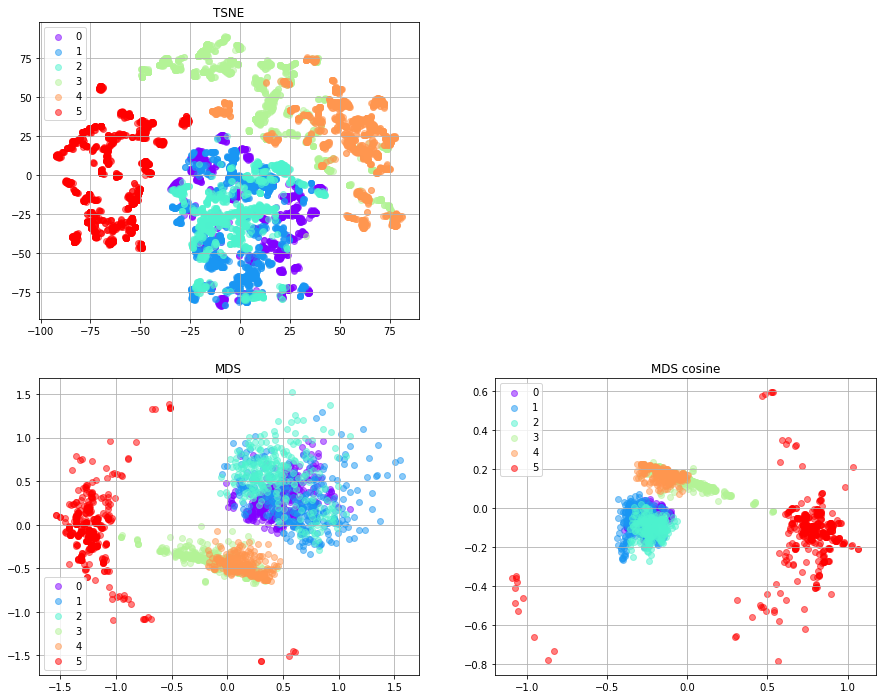

In [13]:
show_separable(df_train[df_train.columns[12:30]], y_train_class)

Отсюда видно, что данные делятся на три кластера: 

В первом кластере - режимы работы 0, 1 и 2; 

Во втором кластере - режимы работы 3 и 4;

В третьем кластере - 6 режим работы, который очень хорошо обосабливается от остальных.

__________________________________________________________
Посмотрим отдельно на классы 0-3 на пространстве всех фич.

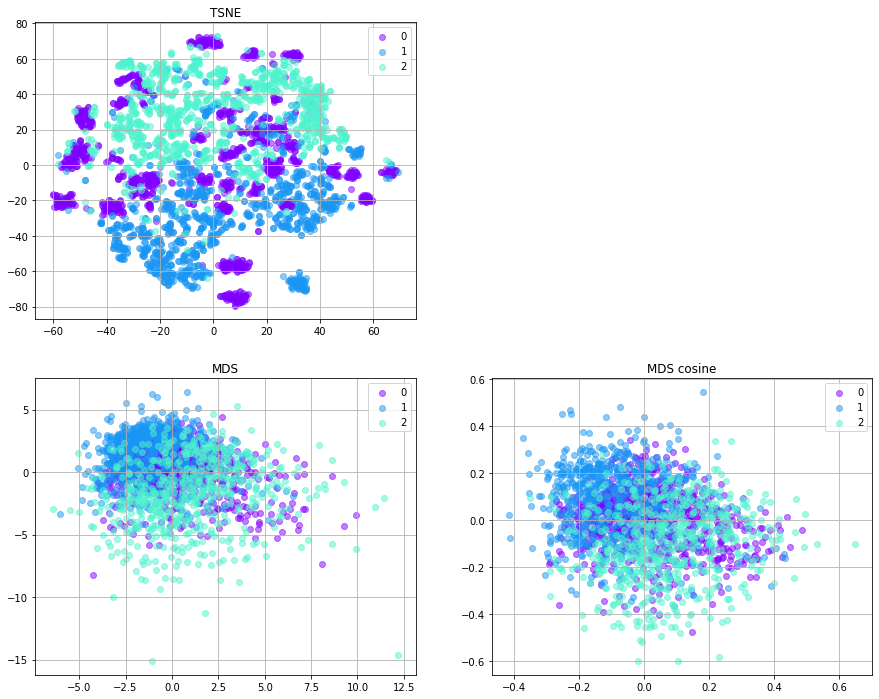

In [14]:
show_separable(x_train_my[y_train_class<3], y_train_class[y_train_class<3])

_______________________________________________________________________________________________________________________
# Train

Посмотрим пару алгоритмов

### Logistic Regression

F1 score: 0.908
Presicion score: 0.912
Recall score: 0.909
ROC-AUC-OVO score: 0.991
ROC-AUC-OVR score: 0.991


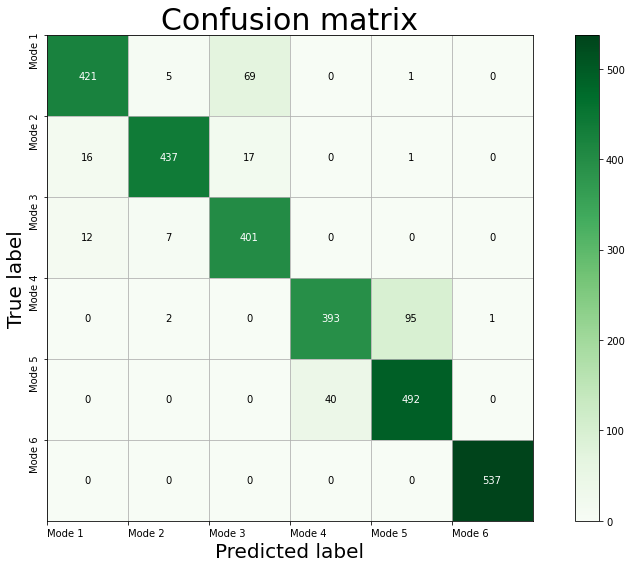

In [15]:
cls_reg = LogisticRegression(solver='lbfgs', max_iter=10000)
scaler  = StandardScaler()

scaler.fit(x_train_my)

x_train_scl = scaler.fit_transform(x_train_my)
x_test_scl  = scaler.transform(x_test_my)

cls_reg.fit(x_train_scl, y_train_class)

y_prob = cls_reg.predict_proba(x_test_scl)

print_metrics(y_test_class, y_prob)

confusion_mtx = confusion_matrix(y_test_class, y_prob.argmax(axis=1))
plot_confusion_matrix(12, 8, confusion_mtx, CLASSES)

### Random Forest

F1 score: 0.913
Presicion score: 0.915
Recall score: 0.912
ROC-AUC-OVO score: 0.994
ROC-AUC-OVR score: 0.993


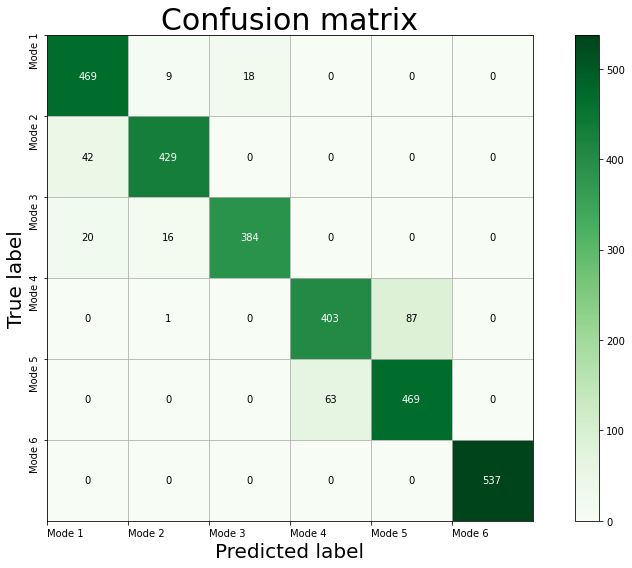

In [16]:
cls_rf = RandomForestClassifier(random_state=2)

cls_rf.fit(x_train_my, y_train_class)

y_prob2 = cls_rf.predict_proba(x_test_my)

print_metrics(y_test_class, y_prob2)

confusion_mtx = confusion_matrix(y_test_class, y_prob2.argmax(axis=1))
plot_confusion_matrix(12, 8, confusion_mtx, CLASSES)

### SVM

In [17]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly']}

grid = GridSearchCV(SVC(probability=True, random_state=2), 
                    param_grid, 
                    refit   = True, 
                    verbose = 3,
                    cv      = 5,
                    n_jobs  = -1)

grid.fit(x_train_scl, y_train_class)

print(grid.best_score_)
print(grid.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0.9158048807558373
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


F1 score: 0.914
Presicion score: 0.917
Recall score: 0.915
ROC-AUC-OVO score: 0.993
ROC-AUC-OVR score: 0.993


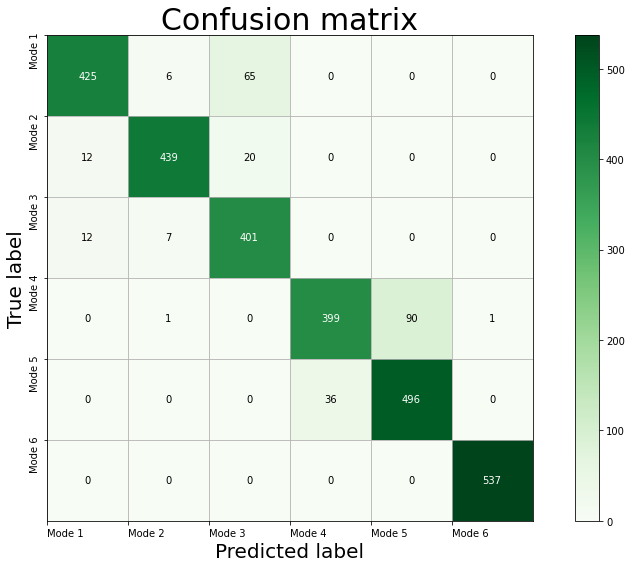

In [18]:
svm = SVC(C=1000, gamma= 0.001, kernel= 'rbf', probability=True, random_state=2)
svm.fit(x_train_scl, y_train_class)

y_prob3 = svm.predict_proba(x_test_scl)

print_metrics(y_test_class, y_prob3)

confusion_mtx = confusion_matrix(y_test_class, y_prob3.argmax(axis=1))
plot_confusion_matrix(12, 8, confusion_mtx, CLASSES)

### RF + LR + SVM

F1 score: 0.917
Presicion score: 0.92
Recall score: 0.918
ROC-AUC-OVO score: 0.995
ROC-AUC-OVR score: 0.995


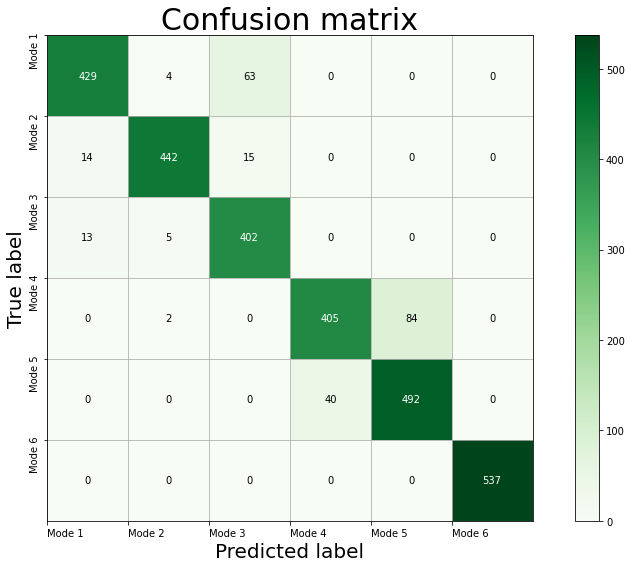

In [19]:
prob_sum = (y_prob+y_prob2+y_prob3)/3
print_metrics(y_test_class, prob_sum)
confusion_mtx = confusion_matrix(y_test_class, prob_sum.argmax(axis=1))
plot_confusion_matrix(12, 8, confusion_mtx, CLASSES)

In [25]:
print(f"numpy=={np.__version__}")
print(f"pandas=={pd.__version__}")
print(f"seaborn=={sns.__version__}")
print(f"matplotlib=={matplotlib.__version__}")
print(f"statsmodels=={statsmodels.__version__}")
print(f"sklearn=={sklearn.__version__}")
print(f"tqdm=={tqdm.__version__}")
print(f"scipy=={scipy.__version__}")

numpy==1.20.3
pandas==1.2.4
seaborn==0.11.1
matplotlib==3.4.2
statsmodels==0.12.2
sklearn==0.24.2
tqdm==4.61.0
scipy==1.6.3
